In [2]:
#Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import sklearn.model_selection as skm 
from sklearn.model_selection import KFold,  GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
#load the cleaned data
data = pd.read_csv("Diabetic_Prediction.csv")
data

,AGE,SEX,BMICALC,HRSLEEP,SODAPNO,FRIESPNO,DIABETICEV
0,61.0,1.0,38.4,8.0,0.0,110.0,1.0
1,43.0,1.0,27.3,6.0,0.0,1.0,1.0
2,68.0,1.0,25.0,6.0,1.0,1.0,1.0
3,73.0,1.0,24.0,8.0,30.0,5.0,1.0
4,73.0,1.0,26.5,6.0,5.0,3.0,1.0
...,...,...,...,...,...,...,...
24248,84.0,2.0,20.7,9.0,0.0,1.0,1.0
24249,45.0,1.0,31.4,8.0,0.0,4.0,1.0
24250,47.0,2.0,36.3,8.0,0.0,1.0,1.0
24251,37.0,2.0,29.0,7.0,4.0,1.0,1.0


In [4]:
#Map target varaibles
data['DIABETICEV'] = data['DIABETICEV'].map({1.0: 0, 2.0: 1}) # 1 = No diabetes, 2 = Has diabetes

# Define feature and target
X = data.drop('DIABETICEV', axis=1)
y = data['DIABETICEV']
# Sample only 5000 rows for tuning
X_sample, _, y_sample, _ = train_test_split(X, y, train_size=5000, random_state=42, stratify=y)
# Split into train and test 
X_train_sample, X_test_sample, y_train_sample, y_test_sample = train_test_split(
    X_sample, y_sample, test_size=0.2, random_state=42, stratify=y_sample)

# Scale features
scaler = StandardScaler()
X_train_sample = scaler.fit_transform(X_train_sample)
X_test_sample = scaler.transform(X_test_sample)


Mapped target variables to 0 and 1. Defined the feature and target variables. Tuning for whole dataset is taking lots of time . so considered subset of the sample took sample of 5000 rows. Scaled the sampled data since it is sensitive to svm. After tuning retrainned rhe final models on the full dataset.

In [5]:
#  Hyperparameter tuning using GridSearchCV
param_grid = {
    'C': [0.01, 0.1, 1,10]
}

svm = SVC(kernel='linear',  random_state=1)
grid_search = GridSearchCV(svm, param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)

grid_search.fit(X_train_sample, y_train_sample)

print("Best parameter:", grid_search.best_params_)


Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best parameter: {'C': 0.01}


Performed hyperparameter tuning for a linear support vector classidier using GridSearchCV with 5- fold cross - validation. The grid search triedfour different values of the regularisation parameter c = 0.01, 0.1, 1and 10, The best parameter found is c = 0.01.

In [6]:

# Split full data
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=1, stratify=y)
# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train the best model
final_svm = SVC(kernel='linear', C=grid_search.best_params_['C'], random_state=1)
final_svm.fit(X_train, y_train)

# Predict and evaluate
y_pred = final_svm.predict(X_test)

print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Test Accuracy: 0.6264687693259122
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.60      0.74      4349
           1       0.19      0.83      0.31       502

    accuracy                           0.63      4851
   macro avg       0.58      0.72      0.53      4851
weighted avg       0.89      0.63      0.70      4851



The test accuracy of model is 62.6%. The classification report shows high precision 0.97 for class 0 but 60% recall. Many actual class 0 samples are not identified by the model. The precision for class 1 is 19% which is very low.

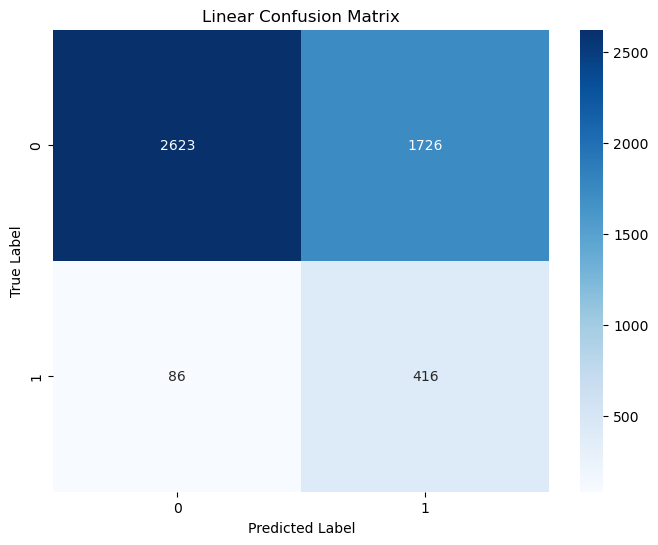

In [7]:
# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=final_svm.classes_, 
            yticklabels=final_svm.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Linear Confusion Matrix')
plt.show()


The model is misclassifying class 0 as class 1, and causing low recall for class 0. It correctly identifies most class 1 cases but makes many false class 1 predictions.

In [8]:
#Tuning using GridSearchCV for RBF kernel
param_grid_rbf = {
    'C': [0.1, 1, 10, 100],
    'gamma': [0.001, 0.01, 0.1, 1]
}

svm_rbf = SVC(kernel='rbf', random_state=1)
grid_rbf = GridSearchCV(svm_rbf, param_grid_rbf, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
grid_rbf.fit(X_train_sample, y_train_sample)
print("Best parameters:", grid_rbf.best_params_)


#  Now train on full dataset for RBF kernel

# Split full data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train the best RBF model
final_svm_rbf = SVC(kernel='rbf', 
                    C=grid_rbf.best_params_['C'], 
                    gamma=grid_rbf.best_params_['gamma'], 
                    random_state=1)
final_svm_rbf.fit(X_train, y_train)

# Predict and evaluate
y_pred = final_svm_rbf.predict(X_test)
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best parameters: {'C': 100, 'gamma': 1}
Test Accuracy: 0.7136672850958565
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.74      0.82      4349
           1       0.18      0.49      0.26       502

    accuracy                           0.71      4851
   macro avg       0.55      0.61      0.54      4851
weighted avg       0.85      0.71      0.76      4851



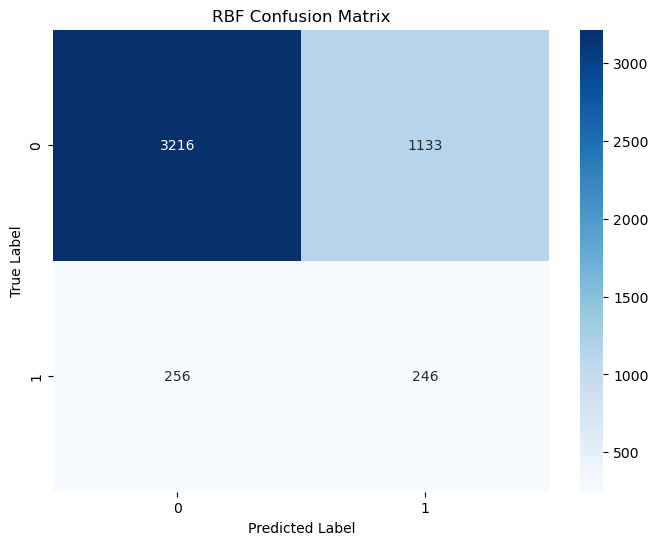

In [58]:
# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=final_svm_rbf.classes_, 
            yticklabels=final_svm_rbf.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('RBF Confusion Matrix')
plt.show()


The RBF SVM model achieved good accuracy of 71.37% in predicting diabetes risk but performed poorly in identifying individuals at risk  with a recall 49% and precision 18%. The confusion matrix shoes that out of 502 actual positives only 246 were correctly identified. 

In [59]:
param_grid_poly = {
    'C': [0.1, 1, 10],
    'degree': [2, 3, 4],
    'gamma': [0.001, 0.01, 0.1]
}

svm_poly = SVC(kernel='poly', random_state=1)
grid_poly = GridSearchCV(svm_poly, param_grid_poly, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
grid_poly.fit(X_train_sample, y_train_sample)
print("Best parameters:", grid_poly.best_params_)

#  Now train on full dataset for Polynomial kernel

# Split full data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state =1, stratify=y)

# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train the best Polynomial model
final_svm_poly = SVC(kernel='poly', 
                     C=grid_poly.best_params_['C'], 
                     degree=grid_poly.best_params_['degree'], 
                     gamma=grid_poly.best_params_['gamma'],
                     random_state=1)
final_svm_poly.fit(X_train, y_train)


# Predict and evaluate
y_pred = final_svm_poly.predict(X_test)

print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best parameters: {'C': 0.1, 'degree': 2, 'gamma': 0.001}
Test Accuracy: 0.10348381776953205
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00      4349
           1       0.10      1.00      0.19       502

    accuracy                           0.10      4851
   macro avg       0.05      0.50      0.09      4851
weighted avg       0.01      0.10      0.02      4851



C:\Users\Sowmy\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Sowmy\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Sowmy\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


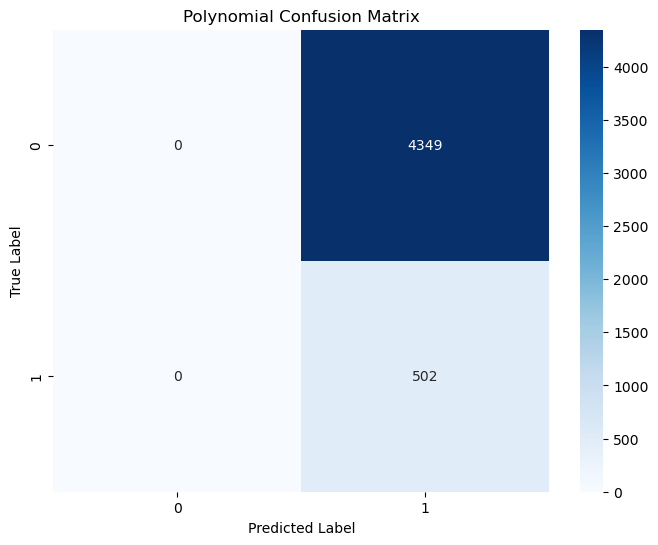

In [60]:
# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=final_svm_poly.classes_, 
            yticklabels=final_svm_poly.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Polynomial Confusion Matrix')
plt.show()


The polynomial SVM model performed extremely poorly, with just 10%. From confusion matrix it is clear that it identified all 502 individuals who truly have diabtes, it falsely labeled 4349 healthy individuals as diabetic.


Now let us plot the decision boundaries for three different SVM models, Linear kernel, RBF kernel, and Polynomial kernel using two scaled features: AGE and BMICALC.

In [61]:
# Select only two features
X_vis = data[['AGE', 'BMICALC']]
y_vis = data['DIABETICEV']
X_train_vis, X_test_vis, y_train_vis, y_test_vis = train_test_split(
    X_vis, y_vis, test_size=0.2, random_state=1, stratify=y_vis)

#  Scale
scaler_vis = StandardScaler()
X_train_vis = scaler_vis.fit_transform(X_train_vis)
X_test_vis = scaler_vis.transform(X_test_vis)

#  Retrain tuned SVM models 

# Linear SVM
svm_linear_vis = SVC(
    kernel='linear',
    C=grid_search.best_params_['C'],
    random_state=1
)
svm_linear_vis.fit(X_train_vis, y_train_vis)

# RBF SVM
svm_rbf_vis = SVC(
    kernel='rbf',
    C=grid_rbf.best_params_['C'],
    gamma=grid_rbf.best_params_['gamma'],
    random_state=1
)
svm_rbf_vis.fit(X_train_vis, y_train_vis)

# Polynomial SVM
svm_poly_vis = SVC(
    kernel='poly',
    C=grid_poly.best_params_['C'],
    degree=grid_poly.best_params_['degree'],
    gamma=grid_poly.best_params_['gamma'],
    random_state=1
)
svm_poly_vis.fit(X_train_vis, y_train_vis)
def plot_decision_boundary(model, X, y, title, sample_size=1000, grid_density=300):
    # Randomly sample smaller points
    if X.shape[0] > sample_size:
        idx = np.random.choice(X.shape[0], sample_size, replace=False)
        X = X[idx]
        y = y.iloc[idx] if hasattr(y, 'iloc') else y[idx]

    # Create smaller grid
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, grid_density),
                         np.linspace(y_min, y_max, grid_density))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(7,5))
    plt.contourf(xx, yy, Z, alpha=0.5)
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', s=15)
    plt.xlabel('AGE (scaled)')
    plt.ylabel('BMICALC (scaled)')
    plt.title(title)
    plt.show()


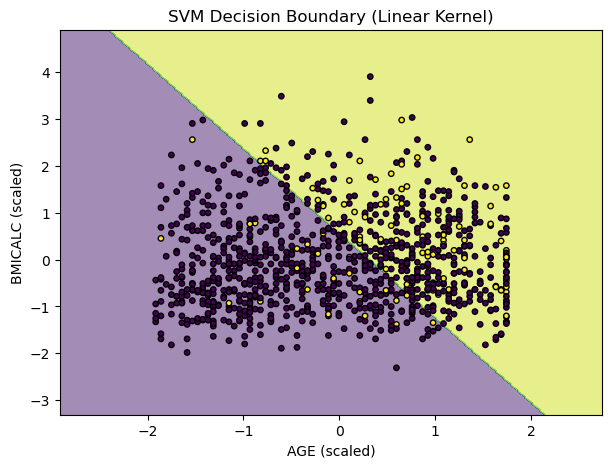

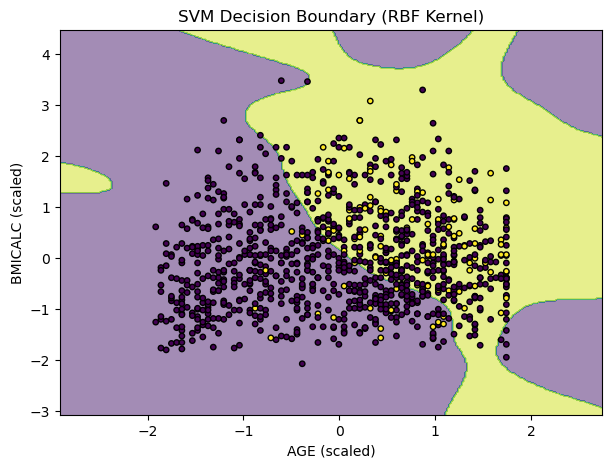

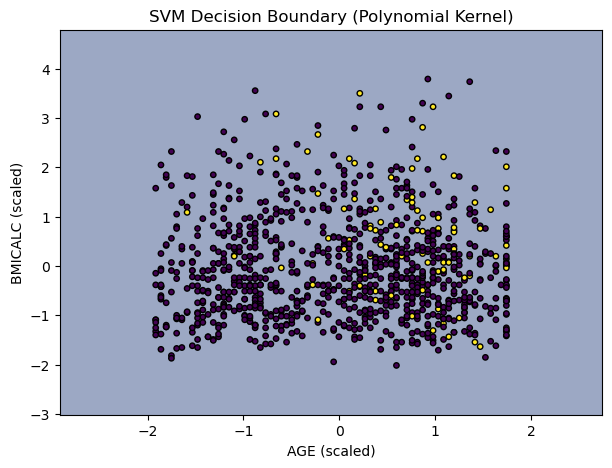

In [62]:
# Plot Linear SVM boundary
plot_decision_boundary(svm_linear_vis, X_train_vis, y_train_vis, 'SVM Decision Boundary (Linear Kernel)')

# Plot RBF SVM boundary
plot_decision_boundary(svm_rbf_vis, X_train_vis, y_train_vis, 'SVM Decision Boundary (RBF Kernel)')

# Plot Polynomial SVM boundary
plot_decision_boundary(svm_poly_vis, X_train_vis, y_train_vis, 'SVM Decision Boundary (Polynomial Kernel)')


The Linear SVM produced a straight boundary, reflecting a simple separation between diabetic and non-diabetic individuals. However, the linear model struggled to fully capture the complexity of the relationship.

The RBF SVM formed a smooth, curved boundary to the data. We can see improved separation of the classes and better overall model performance. It confirming that non-linear patterns exist between health behaviors and diabetes risk.

For the Polynomial SVM created an ineffective and oversimplified boundary, failing to meaningfully separate the two classes. Hence, the RBF kernel provided the most meaningful separation between diabetic and non-diabetic individuals based on scaled AGE and BMI features.

Conclusion:

Support Vector Machine modesls with three kernels, Linear, Radial Basis and Polynomial were used to predict the diabetes based on simple features like age, sex, BMI, sleep habits annd diet. 

After tuning the models the RBF SVM gave the highest overall accuracy 71% making it the most balanced model. The Linear SVM has the highest recall and the Polynomial SVM performed poorly, failed to separate diabetic and non diabteic individuals.

Decision boundary visualizations showed that RBF SVM produced a curved boundary that fit the data better.

Hence, diabetes risk can moderately well preducted using these basic features. Individuals with higher BMI, older age, poor sleep and unhealthy eating habits were more likely to have diabetes. It supports early screening and preventive care. To improve accuracy, additional data like medical history, lab results, and detailed lifestyle would be helpful.